# OONI Data Analysis - Preliminary Exploration

In [1]:
# Imports
from matplotlib import pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import os
from urllib.parse import urlparse

In [2]:
# Plot configuration
seaborn.set_style('dark')

## (1) Data Cleaning
In this step we load and clean up the pre-procsesed data in order to get it into a form that can be analyzed.

In [4]:
# Load the pre-processed data and set up the index based on date
data_dir = '../results/HR/processed/2023/'
web_connectivity = pd.read_csv(os.path.join(data_dir, 'webconnectivity.csv'))
web_connectivity['date'] = pd.to_datetime(web_connectivity['date'])
web_connectivity = web_connectivity.set_index('date')
web_connectivity

,probe_asn,title_match,blocking,http_experiment_failure,status_code_match,control_failure,dns_experiment_failure,input,body_length_match,accessible,x_blocking_flags,dns_consistency,resolver_asn,x_null_null_flags,body_proportion,headers_match,x_dns_flags
date,,,,,,,,,,,,,,,,,
2023-01-01,AS5391,NaN,False,NaN,True,NaN,NaN,https://www.youtube.com/,NaN,True,NaN,consistent,AS5391,NaN,0.000000,True,NaN
2023-01-01,AS5391,NaN,False,NaN,True,NaN,NaN,https://twitter.com/,NaN,True,NaN,consistent,AS5391,NaN,0.000000,True,NaN
2023-01-01,AS5391,NaN,False,NaN,True,NaN,NaN,https://www.facebook.com/,False,True,NaN,consistent,AS5391,NaN,0.669378,True,NaN
2023-01-01,AS5391,NaN,False,NaN,False,NaN,NaN,https://www.instagram.com/,NaN,True,NaN,consistent,AS5391,NaN,0.000000,True,NaN
2023-01-01,AS5391,NaN,False,NaN,True,NaN,NaN,https://www.snapchat.com/,NaN,True,NaN,consistent,AS5391,NaN,0.000000,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31,AS31012,True,False,NaN,True,NaN,NaN,https://www.rferl.org/,True,True,NaN,consistent,AS60068,NaN,0.999992,True,NaN
2023-12-31,AS31012,NaN,False,NaN,True,NaN,NaN,http://www.rfi.fr/,NaN,True,NaN,consistent,AS60068,NaN,0.000000,True,NaN
2023-12-31,AS31012,True,False,NaN,True,NaN,NaN,http://www.righttodie.ca/,True,True,NaN,consistent,AS60068,NaN,1.000000,True,NaN


In [5]:
# Standardize URLs
def url_standardize(url):
    p = urlparse(url)
    b = p.netloc.split('.')
    c = '.'.join(b[len(b)-2:])  # Remove any www
    return c+p.path
    
web_connectivity['input'] = web_connectivity['input'].map(url_standardize)

In [6]:
# Filter data into specific blocking methods
dns_events = web_connectivity[web_connectivity['blocking'] == 'dns']
httpdiff_events = web_connectivity[web_connectivity['blocking'] == 'http-diff']
httpfail_events = web_connectivity[web_connectivity['blocking'] == 'http-failure']
tcp_events = web_connectivity[web_connectivity['blocking'] == 'tcp_ip']
web_connectivity['blocking'].unique()

array(['False', 'tcp_ip', 'http-diff', nan, 'dns', 'http-failure'],
      dtype=object)

## (2) Data Exploration

In [7]:
# Compute rolling totals
k=7
total_events = web_connectivity.groupby(web_connectivity.index).size().rolling(window=k).sum().dropna()
total_dns = dns_events.groupby(dns_events.index).size().rolling(window=k).sum().dropna()
total_httpdiff = httpdiff_events.groupby(httpdiff_events.index).size().rolling(window=k).sum().dropna()
total_httpfail = httpfail_events.groupby(httpfail_events.index).size().rolling(window=k).sum().dropna()
total_tcp = tcp_events.groupby(tcp_events.index).size().rolling(window=k).sum().dropna()

In [8]:
# Compute fractional events
frac_dns = total_dns/total_events
frac_httpdiff = total_httpdiff/total_events
frac_httpfail = total_httpfail/total_events
frac_tcp = total_tcp/total_events
frac_dns = frac_dns.fillna(0)
frac_httpdiff = frac_httpdiff.fillna(0)
frac_httpfail = frac_httpfail.fillna(0)
frac_tcp = frac_tcp.fillna(0)

Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

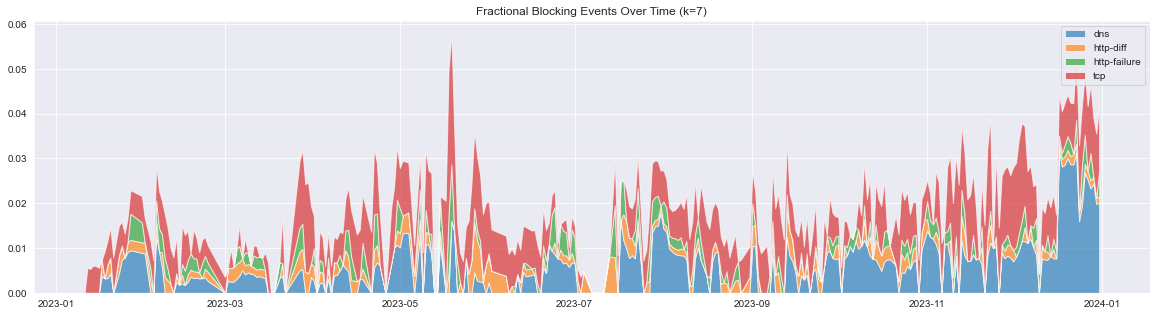

In [9]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

Text(0.5, 1.0, 'Fractional Blocking Events From 2023-03-24-2023-04-18 (k=7)')

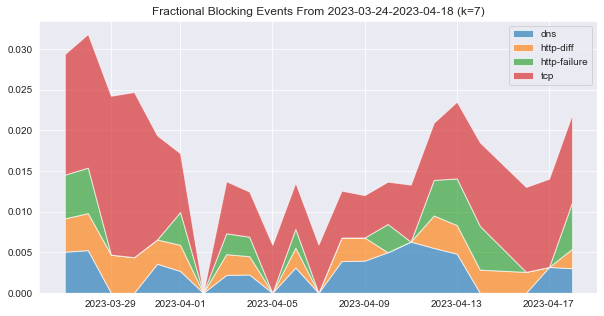

In [11]:
# Zoom in on a region of interest
start_date = '2023-03-24'
end_date = '2023-04-18'
filter_range = total_events.index[(total_events.index >= start_date) & (total_events.index <= end_date)]
plt.rcParams['figure.figsize'] = [10, 5]
plt.stackplot(filter_range, frac_dns[filter_range], frac_httpdiff[filter_range], frac_httpfail[filter_range], frac_tcp[filter_range], labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events From {start_date}-{end_date} (k={k})')

In [12]:
# Get blocking events in small date range
filter_tcp_range = (tcp_events.index >= start_date) & (tcp_events.index <= end_date)
filter_total_range = (web_connectivity.index >= start_date) & (web_connectivity.index <= end_date)
tcp_during = tcp_events[filter_tcp_range].groupby('input').size()
total_during = web_connectivity[filter_total_range].groupby('input').size()
frac_tcp_during = (tcp_during/total_during).fillna(0)
tcp_during.sort_values(ascending=False)
#print((tcp_during/total_during.sum()).sort_values(ascending=False)[:20])
tcp_out = tcp_events[~filter_tcp_range].groupby('input').size()
total_out = web_connectivity[~filter_total_range].groupby('input').size()
frac_tcp_out = (tcp_out/total_out).fillna(0)
#print((tcp_out/total_out.sum()).sort_values(ascending=False)[:20])
diff_frac_tcp = (frac_tcp_during-frac_tcp_out).sort_values(ascending=False).dropna()
diff_frac_tcp[:30]

input
cirp.org/                       0.444444
securevpn.im/                   0.341584
islameyat.com/                  0.205195
mixmin.net/                     0.198496
206.212/tor/server/authority    0.197799
175.225/tor/server/authority    0.187420
qhnews.com/                     0.172328
qhtyzx.com/                     0.169281
i2pforum.net/                   0.159574
sputniknews.cn/                 0.124856
af.mil/                         0.104262
jsf.mil/                        0.099174
gov.cn/                         0.083937
familycareintl.org/             0.070909
blackhat.be/                    0.057143
europedatingonline.com/         0.032338
redd.it/robots.txt              0.032258
org.uk/                         0.000000
org.eg/                         0.000000
org.jm/                         0.000000
opportunity.org/                0.000000
org.au/languages/               0.000000
org.au/                         0.000000
orangewebsite.com/              0.000000
originalel

In [13]:
from statsmodels.stats.proportion import proportions_ztest

blocking_start = "2022-03-24"
blocking_end = "2022-04-18"

inner_range = (web_connectivity.index >= start_date) & (web_connectivity.index <= end_date)
outer_range = (web_connectivity.index < start_date) | (web_connectivity.index > end_date)
tcp_during = web_connectivity[inner_range].groupby('blocking').size()
tcp_outside = web_connectivity[outer_range].groupby('blocking').size()

successes = [tcp_during.sum() - tcp_during["False"], tcp_outside.sum() - tcp_outside["False"]]
sample_sizes = [tcp_during.sum(), tcp_outside.sum()]
print(successes)
print(sample_sizes)
z_stat, p_value = proportions_ztest(successes, sample_sizes)
print(f"Z-Statistic: {z_stat}")
print(f"P-Value: {p_value}")
print(successes[0] / sample_sizes[0])
print(successes[1] / sample_sizes[1])

[249, 5303]
[16566, 269990]
Z-Statistic: -4.17899291911859
P-Value: 2.9280280097567923e-05
0.015030785947120609
0.01964146820252602


In [14]:
import scipy.stats as stats

# Chi-square test of independence of variables
grouped_frame = pd.DataFrame({
    "during": tcp_during,
    "outside": tcp_outside
})
chi2, p_value, dof, expected = stats.chi2_contingency(grouped_frame.T)  # .T to transpose and get the correct format

# Step 3: Output the results
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p_value}")

Chi-square statistic: 52.251810863812615
P-value: 1.2219338043010942e-10


In [15]:
tcp_blocked = tcp_events[filter_tcp_range].groupby('input').size()
print(len(tcp_blocked))
for i, j in tcp_during.items():
    print(str(i) + " " + str(j))

21
False 16317
dns 43
http-diff 36
http-failure 43
tcp_ip 127


Text(0.5, 1.0, 'Fractional Blocking Events Over Time (k=7)')

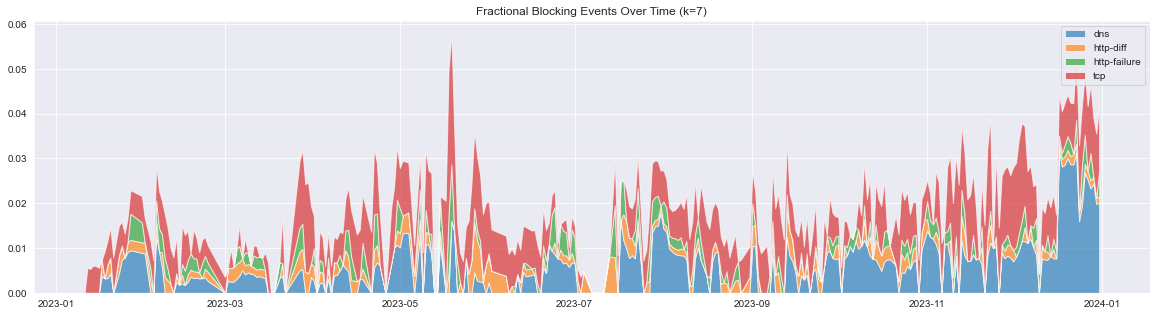

In [16]:
# Plot fractional events
plt.rcParams['figure.figsize'] = [20, 5]
plt.stackplot(total_events.index, frac_dns, frac_httpdiff, frac_httpfail, frac_tcp, labels=['dns', 'http-diff', 'http-failure', 'tcp'], alpha=0.65)
plt.legend()
plt.grid()
plt.title(f'Fractional Blocking Events Over Time (k={k})')

In [17]:
# Extract known blocking methods
web_maybe_blocked = web_connectivity.loc[(web_connectivity['blocking'] != 'False') & (~web_connectivity['blocking'].isnull())]
web_maybe_blocked = web_maybe_blocked.sort_values(by=["input", "date"])
wmbi = web_maybe_blocked.set_index(['input', web_maybe_blocked.index])
wmbi

probe_asn title_match      blocking  \
input            date                                             
0.1/dns-query    2023-07-22   AS15994         NaN  http-failure   
                 2023-07-22   AS15994         NaN  http-failure   
                 2023-07-23   AS15994         NaN  http-failure   
                 2023-07-23   AS15994         NaN  http-failure   
                 2023-07-23   AS15994         NaN  http-failure   
...                               ...         ...           ...   
youtube.com/     2023-04-21   AS13046         NaN        tcp_ip   
                 2023-05-10   AS13046         NaN        tcp_ip   
                 2023-12-17   AS13046         NaN           dns   
zoom.us/zoom.ico 2023-02-14   AS12417         NaN           dns   
zoomshare.com/   2023-02-23    AS5391         NaN        tcp_ip   

                            http_experiment_failure status_code_match  \
input            date                                                   
0.1/dns-query    2023-07-22               eof_error               NaN   
                 2023-07-22               eof_error               NaN   
                 2023-07-23               eof_error               NaN   
                 2023-07-23               eof_error               NaN   
                 2023-07-23               eof_error               NaN   
...                                             ...               ...   
youtube.com/     2023-04-21     network_unreachable               NaN   
                 2023-05-10     network_unreachable               NaN   
                 2023-12-17                     NaN               NaN   
zoom.us/zoom.ico 2023-02-14   generic_timeout_error               NaN   
zoomshare.com/   2023-02-23   generic_timeout_error               NaN   

                            control_failure     dns_experiment_failure  \
input            date                                                    
0.1/dns-query    2023-07-22             NaN                        NaN   
                 2023-07-22             NaN                        NaN   
                 2023-07-23             NaN                        NaN   
                 2023-07-23             NaN                        NaN   
                 2023-07-23             NaN                        NaN   
...                                     ...                        ...   
youtube.com/     2023-04-21             NaN                        NaN   
                 2023-05-10             NaN                        NaN   
                 2023-12-17             NaN  android_dns_cache_no_data   
zoom.us/zoom.ico 2023-02-14             NaN                        NaN   
zoomshare.com/   2023-02-23             NaN                        NaN   

                            body_length_match accessible  x_blocking_flags  \
input            date                                                        
0.1/dns-query    2023-07-22               NaN      False               NaN   
                 2023-07-22               NaN      False               NaN   
                 2023-07-23               NaN      False               NaN   
                 2023-07-23               NaN      False               NaN   
                 2023-07-23               NaN      False               NaN   
...                                       ...        ...               ...   
youtube.com/     2023-04-21               NaN      False               NaN   
                 2023-05-10               NaN      False               NaN   
                 2023-12-17               NaN      False               NaN   
zoom.us/zoom.ico 2023-02-14               NaN      False               NaN   
zoomshare.com/   2023-02-23               NaN      False               NaN   

                            dns_consistency resolver_asn  x_null_null_flags  \
input            date                                                         
0.1/dns-query    2023-07-22      consistent      AS12810              

In [18]:
# Find sites with largest number of blocking events
topw = wmbi.groupby(level=0).size().sort_values(ascending=False)
topw

input
kiwifarms.net/                 292
gaytoday.com/                  195
vesti.ru/                      155
mywebcalls.com/                152
smotrim.ru/                    145
                              ... 
opennet.net/                     1
openpgp.org/                     1
opensocietyfoundations.org/      1
opioids.com/                     1
zoomshare.com/                   1
Length: 523, dtype: int64

In [19]:
# Get data from the top blocking events
wmbi.loc[topw[topw > 10].index]

probe_asn title_match      blocking  \
input             date                                             
kiwifarms.net/    2023-01-27    AS5391         NaN  http-failure   
                  2023-03-20   AS12417         NaN           dns   
                  2023-03-27    AS5391         NaN  http-failure   
                  2023-04-12    AS1886         NaN  http-failure   
                  2023-05-08    AS5391         NaN        tcp_ip   
...                                ...         ...           ...   
goldenpalace.com/ 2023-10-07   AS31012         NaN           dns   
                  2023-10-27    AS5391         NaN           dns   
                  2023-12-23   AS31012         NaN           dns   
                  2023-12-23   AS31012         NaN           dns   
                  2023-12-24   AS31012         NaN           dns   

                             http_experiment_failure status_code_match  \
input             date                                                   
kiwifarms.net/    2023-01-27   generic_timeout_error               NaN   
                  2023-03-20                     NaN               NaN   
                  2023-03-27        connection_reset               NaN   
                  2023-04-12   generic_timeout_error               NaN   
                  2023-05-08      connection_refused               NaN   
...                                              ...               ...   
goldenpalace.com/ 2023-10-07    ssl_invalid_hostname               NaN   
                  2023-10-27    ssl_invalid_hostname               NaN   
                  2023-12-23    ssl_invalid_hostname               NaN   
                  2023-12-23    ssl_invalid_hostname               NaN   
                  2023-12-24    ssl_invalid_hostname               NaN   

                             control_failure dns_experiment_failure  \
input             date                                                
kiwifarms.net/    2023-01-27             NaN                    NaN   
                  2023-03-20             NaN     dns_nxdomain_error   
                  2023-03-27             NaN                    NaN   
                  2023-04-12             NaN                    NaN   
                  2023-05-08             NaN                    NaN   
...                                      ...                    ...   
goldenpalace.com/ 2023-10-07             NaN                    NaN   
                  2023-10-27             NaN                    NaN   
                  2023-12-23             NaN                    NaN   
                  2023-12-23             NaN                    NaN   
                  2023-12-24             NaN                    NaN   

                             body_length_match accessible  x_blocking_flags  \
input             date                                                        
kiwifarms.net/    2023-01-27               NaN      False               NaN   
                  2023-03-20               NaN      False               NaN   
                  2023-03-27               NaN      False               NaN   
                  2023-04-12               NaN      False               NaN   
                  2023-05-08               NaN      False               NaN   
...                                        ...        ...               ...   
goldenpalace.com/ 2023-10-07               NaN      False               NaN   
                  2023-10-27               NaN      False               NaN   
                  2023-12-23               NaN      False               NaN   
                  2023-12-23               NaN      False               NaN   
                  2023-12-24               NaN      False               NaN   

                             dns_consistency resolver_asn  x_null_null_flags  \
input             date                                                         
kiwifarms.net/    2023-01-27      consistent       AS5391            

In [20]:
sel = wmbi.loc[topw[topw > 10].index].loc[topw.index[10]]
ma = sel['blocking'] == 'dns'
sel[ma]

,probe_asn,title_match,blocking,http_experiment_failure,status_code_match,control_failure,dns_experiment_failure,body_length_match,accessible,x_blocking_flags,dns_consistency,resolver_asn,x_null_null_flags,body_proportion,headers_match,x_dns_flags
date,,,,,,,,,,,,,,,,
2023-01-02,AS5391,NaN,dns,connection_refused,NaN,NaN,NaN,NaN,False,NaN,inconsistent,AS5391,NaN,0.0,NaN,NaN
2023-01-02,AS5391,NaN,dns,connection_refused,NaN,NaN,NaN,NaN,False,NaN,inconsistent,AS5391,NaN,0.0,NaN,NaN
2023-01-02,AS5391,NaN,dns,connection_refused,NaN,NaN,NaN,NaN,False,NaN,inconsistent,AS5391,NaN,0.0,NaN,NaN
2023-01-08,AS5391,NaN,dns,connection_refused,NaN,NaN,NaN,NaN,False,NaN,inconsistent,AS5391,NaN,0.0,NaN,NaN
2023-01-13,AS5391,NaN,dns,connection_refused,NaN,NaN,NaN,NaN,False,NaN,inconsistent,AS5391,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-17,AS13046,NaN,dns,connection_refused,NaN,NaN,NaN,NaN,False,NaN,inconsistent,AS13046,NaN,0.0,NaN,NaN
2023-12-17,AS13046,NaN,dns,connection_refused,NaN,NaN,NaN,NaN,False,NaN,inconsistent,AS13046,NaN,0.0,NaN,NaN
2023-12-19,AS5391,NaN,dns,connection_refused,NaN,NaN,NaN,NaN,False,NaN,inconsistent,AS5391,NaN,0.0,NaN,NaN


In [21]:
web_connectivity.loc[web_connectivity['input'] == topw.index[0]]

,probe_asn,title_match,blocking,http_experiment_failure,status_code_match,control_failure,dns_experiment_failure,input,body_length_match,accessible,x_blocking_flags,dns_consistency,resolver_asn,x_null_null_flags,body_proportion,headers_match,x_dns_flags
date,,,,,,,,,,,,,,,,,
2023-01-01,AS5391,NaN,False,NaN,True,NaN,NaN,kiwifarms.net/,NaN,True,NaN,consistent,AS5391,NaN,0.0,True,NaN
2023-01-01,AS5391,NaN,False,NaN,True,NaN,NaN,kiwifarms.net/,NaN,True,NaN,consistent,AS5391,NaN,0.0,True,NaN
2023-01-01,AS5391,NaN,False,NaN,True,NaN,NaN,kiwifarms.net/,NaN,True,NaN,consistent,AS5391,NaN,0.0,True,NaN
2023-01-02,AS5391,NaN,False,NaN,True,NaN,NaN,kiwifarms.net/,NaN,True,NaN,consistent,AS5391,NaN,0.0,True,NaN
2023-01-02,AS5391,NaN,False,NaN,True,NaN,NaN,kiwifarms.net/,NaN,True,NaN,consistent,AS5391,NaN,0.0,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,AS31012,True,False,NaN,True,NaN,NaN,kiwifarms.net/,True,True,NaN,consistent,AS60068,NaN,1.0,True,NaN
2023-12-27,AS31012,True,False,NaN,True,NaN,NaN,kiwifarms.net/,True,True,NaN,consistent,AS60068,NaN,1.0,True,NaN
2023-12-28,AS5391,NaN,http-failure,generic_timeout_error,NaN,NaN,NaN,kiwifarms.net/,NaN,False,NaN,consistent,AS5391,NaN,0.0,NaN,NaN


In [22]:
# Group all events by input calculate totals
dns_grouped = dns_events.groupby('input').size() # sort_values(ascending=False)
httpdiff_grouped = httpdiff_events.groupby('input').size()
httpfail_grouped = httpfail_events.groupby('input').size()
tcp_grouped = tcp_events.groupby('input').size()
totals_grouped = web_connectivity.groupby('input').size()

In [23]:
noblock_events = web_connectivity[(web_connectivity['blocking'] == 'False') | (web_connectivity['blocking'].isnull())]
noblock_grouped = noblock_events.groupby('input').size()

In [24]:
# Calculate fraction of events blocked per input
frac_dns_grouped = (dns_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpdiff_grouped = (httpdiff_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_httpfail_grouped = (httpfail_grouped / totals_grouped).dropna().sort_values(ascending=False)
frac_tcp_grouped = (tcp_grouped / totals_grouped).dropna().sort_values(ascending=False)

In [25]:
# Get all events grouped by the type of blocking event
all_grouped = pd.DataFrame({'dns': frac_dns_grouped, 'httpdiff': frac_httpdiff_grouped, 'httpfail': frac_httpfail_grouped, 'tcp': frac_tcp_grouped}).fillna(0)
all_grouped

,dns,httpdiff,httpfail,tcp
input,,,,
0.1/dns-query,0.000000,0.0,0.024510,0.000000
0.3/dns-query,0.000000,0.0,0.000000,0.005263
1.1/dns-query,0.000000,0.0,0.018018,0.000000
1337x.to/,0.000000,0.0,0.031496,0.000000
164.118/tor/server/authority,0.000000,0.0,0.006623,0.000000
...,...,...,...,...
yandex.net/i,0.010929,0.0,0.000000,0.775956
yandex.net/robots.txt,0.002309,0.0,0.000000,0.000000
youtube.com/,0.000274,0.0,0.000274,0.000548


In [26]:
# Extract the top N sites
nn = 100
top_n_idx = all_grouped.sum(axis=1).sort_values(ascending=False)[0:nn].index
top_n = all_grouped.loc[top_n_idx]
top_n

,dns,httpdiff,httpfail,tcp
input,,,,
sputniknews.com,1.000000,0.000000,0.00000,0.000000
rt.com,1.000000,0.000000,0.00000,0.000000
oic-oci.org/,0.000000,0.000000,0.00000,0.923077
jsf.mil/,0.000000,0.000000,0.00000,0.904000
itsyoursexlife.com/,0.000000,0.000000,0.00000,0.902256
...,...,...,...,...
railfan.net/,0.000000,0.056497,0.00565,0.000000
serials.ws/,0.061947,0.000000,0.00000,0.000000
weblogs.us/,0.000000,0.000000,0.00000,0.060606


In [27]:
# Calculate cumulative values
c_top_n = top_n.cumsum(axis=1)

Text(0.5, 0, 'Fraction of events')

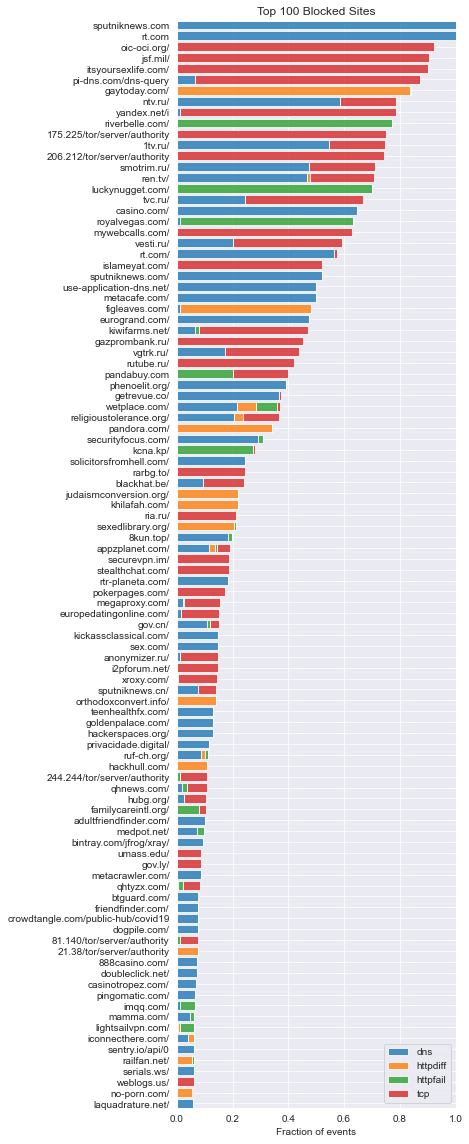

In [28]:
# Plot 
plt.rcParams['figure.figsize'] = [5, 20]
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['dns'].iloc[::-1], label='dns', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpdiff'].iloc[::-1], left=c_top_n.iloc[::-1,0], label='httpdiff', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['httpfail'].iloc[::-1], left=c_top_n.iloc[::-1,1], label='httpfail', alpha=0.8)
plt.barh(top_n.index[::-1].str.slice(0,60), top_n['tcp'].iloc[::-1], left=c_top_n.iloc[::-1,2], label='tcp', alpha=0.8)
plt.margins(y=0)
plt.legend()
plt.grid()
plt.title(f'Top {nn} Blocked Sites')
plt.xlabel('Fraction of events')